In [1]:
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import json

import huggingface_hub
from huggingface_hub import hf_hub_download

from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification

import torch
from torch.utils.data import RandomSampler

from torch.utils.data import DataLoader, Dataset

from transformers import TrainingArguments, Trainer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os

## Selección del Dataset

Dataset: [food101](https://huggingface.co/datasets/ethz/food101) \
This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

## EDA

In [235]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:

# huggingface_hub.notebook_login()

hf_dataset_id = "ethz/food101"
ds = load_dataset(hf_dataset_id)
id2label = json.load(open("id2label.json"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {label:id for id,label in id2label.items()}
numclasses = len(id2label)
print(id2label)
print(numclasses)

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake', 15: 'ceviche', 16: 'cheesecake', 17: 'cheese_plate', 18: 'chicken_curry', 19: 'chicken_quesadilla', 20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder', 25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes', 30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots', 36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt', 46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon', 51: 'guacamole

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [4]:
trainds = ds['train']
testds = ds['validation']

### Analisis de los datos internamente
Dejo todo comentado luego de terminar, para no volver a correr esto cada vez.

In [ ]:
# # Voy a analizar el formato de las imagenes para ver como son
# Lo comento ahora porque ya obtuve lo que necesitaba y consume tiempo y memoria

# imagenesdata = trainds['image']
# imagenesdata_test = testds['image']

In [ ]:


# imagenes_mode = [i.mode for i in imagenesdata]
# imagenes_format = [i.format for i in imagenesdata]
# imagenes_shape = [i.size for i in imagenesdata]
# print(set(imagenes_mode))
# print(set(imagenes_format))
# print(set(imagenes_shape))
# print('imagenes en escala de grises:\n', [i for i in range(len(imagenes_mode)) if imagenes_mode[i] == 'L'])

# El resultado fue

# {'L', 'RGB'}
# {'JPEG', None}
# {(308, 512), (319, 512), (453, 512), (512, 409), (512, 418), (512, 427), (512, 436), (376, 512), (512, 445), (510, 512), (415, 512), (512, 274), (512, 283), (512, 292), (512, 301), (338, 512), (512, 310), (494, 512), (483, 512), (472, 512), (377, 512), (512, 404), (445, 512), (512, 413), (512, 422), (512, 431), (512, 440), (512, 269), (512, 278), (512, 287), (512, 296), (512, 305), (464, 512), (475, 512), (512, 390), (349, 512), (512, 399), (512, 408), (512, 417), (512, 426), (417, 512), (456, 512), (512, 273), (512, 511), (512, 291), (379, 512), (368, 512), (390, 512), (512, 376), (512, 385), (512, 394), (447, 512), (512, 403), (341, 512), (330, 512), (512, 412), (486, 512), (512, 241), (512, 259), (409, 512), (512, 268), (512, 506), (512, 277), (437, 512), (448, 512), (371, 512), (505, 512), (512, 371), (410, 512), (512, 380), (399, 512), (512, 389), (512, 398), (512, 407), (333, 512), (322, 512), (467, 512), (512, 236), (512, 254), (512, 492), (512, 501), (512, 510), (440, 512), (429, 512), (418, 512), (512, 357), (512, 366), (512, 375), (512, 384), (512, 393), (512, 222), (512, 231), (459, 512), (512, 249), (512, 487), (512, 496), (512, 505), (344, 512), (512, 352), (512, 361), (401, 512), (412, 512), (512, 370), (306, 512), (512, 379), (512, 388), (385, 512), (374, 512), (512, 226), (508, 512), (512, 473), (512, 482), (512, 253), (512, 491), (512, 500), (442, 512), (512, 509), (325, 512), (470, 512), (512, 338), (512, 347), (512, 356), (512, 365), (404, 512), (393, 512), (512, 374), (287, 512), (432, 512), (512, 230), (512, 468), (512, 239), (511, 512), (500, 512), (512, 477), (489, 512), (512, 486), (394, 512), (512, 495), (512, 504), (512, 333), (451, 512), (512, 342), (512, 351), (512, 360), (512, 369), (279, 512), (435, 512), (424, 512), (413, 512), (512, 454), (512, 225), (512, 463), (512, 472), (512, 481), (492, 512), (512, 490), (512, 319), (366, 512), (512, 328), (512, 337), (512, 346), (454, 512), (443, 512), (512, 355), (339, 512), (328, 512), (512, 449), (512, 220), (512, 458), (512, 467), (407, 512), (396, 512), (512, 476), (512, 485), (512, 314), (512, 323), (512, 332), (358, 512), (512, 341), (503, 512), (512, 350), (426, 512), (512, 188), (331, 512), (320, 512), (512, 435), (465, 512), (512, 444), (512, 453), (512, 462), (512, 471), (388, 512), (512, 300), (427, 512), (512, 309), (512, 318), (512, 327), (512, 336), (350, 512), (506, 512), (484, 512), (512, 165), (512, 421), (512, 430), (512, 439), (301, 512), (312, 512), (512, 448), (457, 512), (446, 512), (512, 457), (512, 286), (512, 295), (512, 304), (512, 313), (408, 512), (419, 512), (512, 322), (487, 512), (512, 416), (512, 425), (512, 434), (361, 512), (512, 443), (512, 452), (438, 512), (449, 512), (512, 281), (512, 290), (512, 299), (323, 512), (512, 308), (512, 317), (380, 512), (391, 512), (402, 512), (512, 402), (512, 411), (512, 182), (512, 420), (512, 429), (512, 438), (342, 512), (498, 512), (512, 267), (512, 276), (512, 285), (512, 294), (421, 512), (512, 303), (304, 512), (383, 512), (512, 397), (512, 415), (411, 512), (512, 424), (512, 433), (512, 262), (345, 512), (490, 512), (479, 512), (512, 271), (373, 512), (512, 280), (512, 289), (512, 298), (307, 512), (296, 512), (512, 383), (512, 392), (512, 401), (512, 410), (509, 512), (512, 419), (403, 512), (512, 257), (512, 266), (512, 275), (471, 512), (460, 512), (512, 284), (356, 512), (512, 122), (288, 512), (512, 140), (433, 512), (512, 378), (512, 387), (512, 396), (512, 405), (512, 414), (512, 243), (512, 252), (386, 512), (512, 499), (375, 512), (512, 508), (348, 512), (512, 364), (482, 512), (512, 373), (512, 382), (512, 391), (512, 400), (405, 512), (416, 512), (512, 229), (444, 512), (193, 512), (512, 247), (512, 256), (512, 494), (512, 265), (512, 503), (367, 512), (378, 512), (512, 512), (501, 512), (406, 512), (512, 359), (512, 368), (340, 512), (329, 512), (512, 377), (474, 512), (223, 512), (512, 386), (512, 395), (397, 512), (425, 512), (512, 480), (512, 489), (512, 498), (512, 507), (359, 512), (493, 512), (504, 512), (242, 512), (398, 512), (387, 512), (512, 345), (512, 354), (512, 363), (512, 372), (512, 381), (455, 512), (466, 512), (512, 210), (512, 228), (512, 466), (512, 475), (512, 246), (512, 484), (428, 512), (512, 493), (512, 502), (512, 331), (485, 512), (512, 340), (512, 349), (512, 358), (512, 367), (381, 512), (512, 461), (512, 232), (512, 470), (332, 512), (477, 512), (512, 479), (512, 488), (512, 497), (389, 512), (512, 326), (400, 512), (512, 335), (512, 344), (512, 353), (512, 362), (468, 512), (351, 512), (507, 512), (496, 512), (512, 447), (512, 218), (512, 456), (512, 465), (512, 474), (324, 512), (512, 483), (458, 512), (469, 512), (512, 312), (512, 321), (512, 330), (512, 339), (512, 348), (420, 512), (431, 512), (343, 512), (499, 512), (488, 512), (512, 442), (382, 512), (512, 451), (512, 460), (512, 469), (512, 478), (439, 512), (450, 512), (512, 307), (512, 316), (512, 325), (512, 334), (512, 343), (423, 512), (512, 181), (392, 512), (512, 428), (512, 437), (512, 446), (480, 512), (512, 455), (512, 464), (365, 512), (354, 512), (512, 293), (512, 302), (512, 311), (512, 320), (512, 329), (512, 423), (512, 432), (395, 512), (384, 512), (512, 441), (289, 512), (512, 450), (512, 459), (512, 288), (512, 297), (346, 512), (357, 512), (502, 512), (512, 306), (491, 512), (512, 315), (512, 324), (414, 512)}
# imagenes en escala de grises:
#  [18508, 23754, 56094]

{'L', 'RGB'}
{'JPEG', None}
{(308, 512), (319, 512), (453, 512), (512, 409), (512, 418), (512, 427), (512, 436), (376, 512), (512, 445), (510, 512), (415, 512), (512, 274), (512, 283), (512, 292), (512, 301), (338, 512), (512, 310), (494, 512), (483, 512), (472, 512), (377, 512), (512, 404), (445, 512), (512, 413), (512, 422), (512, 431), (512, 440), (512, 269), (512, 278), (512, 287), (512, 296), (512, 305), (464, 512), (475, 512), (512, 390), (349, 512), (512, 399), (512, 408), (512, 417), (512, 426), (417, 512), (456, 512), (512, 273), (512, 511), (512, 291), (379, 512), (368, 512), (390, 512), (512, 376), (512, 385), (512, 394), (447, 512), (512, 403), (341, 512), (330, 512), (512, 412), (486, 512), (512, 241), (512, 259), (409, 512), (512, 268), (512, 506), (512, 277), (437, 512), (448, 512), (371, 512), (505, 512), (512, 371), (410, 512), (512, 380), (399, 512), (512, 389), (512, 398), (512, 407), (333, 512), (322, 512), (467, 512), (512, 236), (512, 254), (512, 492), (512, 501),

In [ ]:
# imagenes_mode_test = [i.mode for i in imagenesdata_test]
# imagenes_format_test = [i.format for i in imagenesdata_test]
# imagenes_shape_test = [i.size for i in imagenesdata_test]
# print(set(imagenes_mode_test))
# print(set(imagenes_format_test))
# print(set(imagenes_shape_test))
# print('imagenes en escala de grises:\n', [i for i in range(len(imagenes_mode_test)) if imagenes_mode_test[i] == 'L'])

# {'RGB'}
# {'JPEG', None}
# {(398, 512), (308, 512), (512, 281), (385, 512), (453, 512), (512, 226), (508, 512), (512, 409), (512, 290), (512, 354), (512, 345), (512, 299), (512, 418), (512, 363), (512, 482), (512, 308), (512, 372), (512, 491), (512, 317), (512, 436), (512, 381), (512, 500), (466, 512), (512, 445), (510, 512), (512, 509), (380, 512), (512, 347), (512, 466), (512, 356), (512, 475), (512, 301), (512, 420), (512, 365), (512, 484), (512, 310), (404, 512), (472, 512), (512, 374), (512, 493), (512, 429), (512, 438), (287, 512), (298, 512), (342, 512), (512, 502), (432, 512), (302, 512), (512, 331), (512, 276), (512, 340), (512, 404), (512, 349), (512, 468), (512, 294), (512, 413), (445, 512), (511, 512), (512, 358), (500, 512), (512, 422), (512, 477), (512, 367), (304, 512), (394, 512), (370, 512), (381, 512), (512, 495), (512, 504), (512, 333), (383, 512), (512, 397), (512, 342), (451, 512), (512, 287), (512, 406), (462, 512), (512, 351), (512, 470), (332, 512), (512, 415), (411, 512), (512, 360), (512, 479), (512, 305), (512, 424), (512, 369), (512, 488), (512, 433), (512, 497), (475, 512), (512, 262), (413, 512), (479, 512), (512, 326), (512, 271), (512, 390), (512, 335), (294, 512), (512, 399), (349, 512), (512, 344), (512, 463), (512, 289), (512, 408), (346, 512), (512, 353), (512, 472), (512, 298), (512, 417), (512, 362), (512, 426), (468, 512), (512, 490), (307, 512), (351, 512), (452, 512), (507, 512), (512, 432), (496, 512), (512, 319), (512, 383), (512, 328), (456, 512), (512, 392), (512, 511), (512, 337), (512, 282), (512, 401), (512, 346), (512, 465), (443, 512), (512, 410), (509, 512), (512, 355), (430, 512), (512, 291), (512, 474), (454, 512), (512, 483), (379, 512), (403, 512), (339, 512), (512, 312), (512, 376), (512, 321), (512, 385), (512, 330), (512, 449), (512, 394), (471, 512), (512, 339), (387, 512), (512, 403), (512, 348), (341, 512), (512, 467), (512, 412), (396, 512), (486, 512), (512, 476), (356, 512), (288, 512), (512, 314), (343, 512), (512, 378), (499, 512), (409, 512), (512, 442), (512, 268), (512, 387), (512, 506), (512, 332), (382, 512), (512, 323), (512, 396), (512, 213), (512, 341), (503, 512), (512, 460), (512, 405), (512, 350), (512, 469), (512, 414), (512, 478), (320, 512), (450, 512), (426, 512), (512, 307), (505, 512), (512, 371), (512, 316), (512, 435), (410, 512), (512, 380), (386, 512), (512, 325), (512, 499), (375, 512), (512, 389), (512, 508), (512, 334), (512, 398), (512, 343), (512, 407), (512, 471), (333, 512), (423, 512), (388, 512), (512, 364), (392, 512), (482, 512), (512, 428), (512, 254), (512, 373), (512, 492), (512, 318), (512, 309), (427, 512), (512, 382), (512, 501), (512, 446), (480, 512), (512, 391), (512, 510), (512, 272), (512, 455), (512, 336), (512, 400), (429, 512), (440, 512), (506, 512), (512, 464), (484, 512), (354, 512), (365, 512), (512, 293), (444, 512), (512, 357), (512, 421), (512, 366), (512, 256), (512, 375), (497, 512), (512, 320), (512, 439), (512, 494), (512, 384), (512, 503), (512, 329), (301, 512), (446, 512), (512, 393), (512, 512), (501, 512), (512, 457), (316, 512), (327, 512), (512, 295), (512, 304), (512, 423), (512, 487), (512, 313), (408, 512), (384, 512), (463, 512), (512, 496), (474, 512), (512, 322), (340, 512), (512, 386), (289, 512), (512, 505), (344, 512), (512, 377), (512, 395), (512, 450), (512, 459), (487, 512), (512, 288), (512, 352), (357, 512), (425, 512), (512, 361), (502, 512), (512, 306), (512, 425), (512, 480), (512, 370), (512, 489), (306, 512), (512, 434), (512, 260), (512, 379), (512, 498), (512, 324), (512, 443), (512, 388), (512, 507), (512, 452), (438, 512)}
# imagenes en escala de grises:
#  []


{'RGB'}
{'JPEG', None}
{(398, 512), (308, 512), (512, 281), (385, 512), (453, 512), (512, 226), (508, 512), (512, 409), (512, 290), (512, 354), (512, 345), (512, 299), (512, 418), (512, 363), (512, 482), (512, 308), (512, 372), (512, 491), (512, 317), (512, 436), (512, 381), (512, 500), (466, 512), (512, 445), (510, 512), (512, 509), (380, 512), (512, 347), (512, 466), (512, 356), (512, 475), (512, 301), (512, 420), (512, 365), (512, 484), (512, 310), (404, 512), (472, 512), (512, 374), (512, 493), (512, 429), (512, 438), (287, 512), (298, 512), (342, 512), (512, 502), (432, 512), (302, 512), (512, 331), (512, 276), (512, 340), (512, 404), (512, 349), (512, 468), (512, 294), (512, 413), (445, 512), (511, 512), (512, 358), (500, 512), (512, 422), (512, 477), (512, 367), (304, 512), (394, 512), (370, 512), (381, 512), (512, 495), (512, 504), (512, 333), (383, 512), (512, 397), (512, 342), (451, 512), (512, 287), (512, 406), (462, 512), (512, 351), (512, 470), (332, 512), (512, 415), (411

In [ ]:
# # libero memoria
# del imagenesdata
# del imagenesdata_test
# del imagenes_mode
# del imagenes_format
# del imagenes_shape
# del imagenes_mode_test
# del imagenes_format_test
# del imagenes_shape_test

In [ ]:
# Se ve que algunas imagenes están en modo 'L' en el set de entrenamiento. Lo que causa error. Además no tienen nada que ver con comida, aunque tengan label.
print(trainds[18508, 23754, 56094]['image'])
print(trainds[18508, 23754, 56094]['label'])

[<PIL.JpegImagePlugin.JpegImageFile image mode=L size=510x512 at 0x23F76020B50>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x348 at 0x23F76020310>, <PIL.Image.Image image mode=L size=412x512 at 0x23F7601DE10>]
[93, 59, 8]


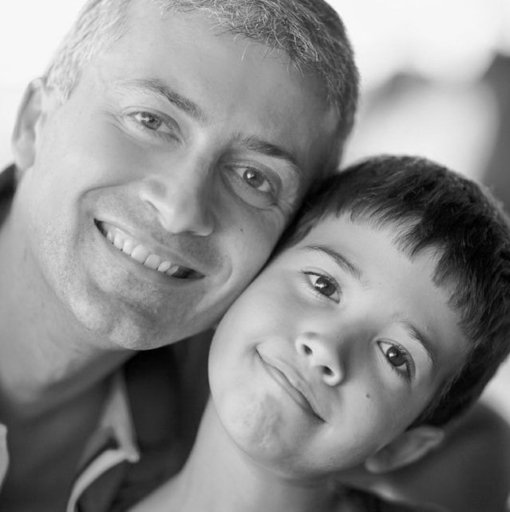

In [13]:
trainds[18508]['image']

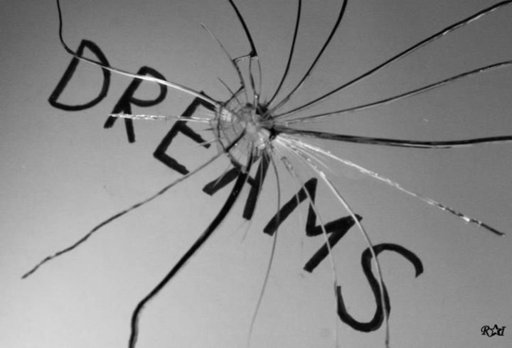

In [14]:
trainds[23754]['image']

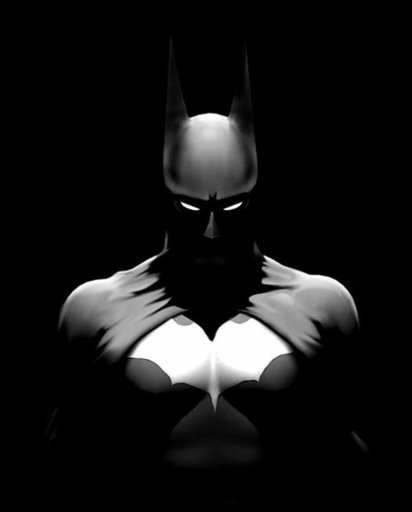

In [15]:
trainds[56094]['image']

In [ ]:

# Voy a quitar los indices que causan problemas
exclude_idx = [18508, 23754, 56094]

# create new dataset exluding those idx
trainds = trainds.select(
    (
        i for i in range(len(trainds)) 
        if i not in set(exclude_idx)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x0000024199C2DE00> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [28]:
# trainds = trainds.shuffle().select(range(15000))
# testds = testds.shuffle().select(range(2000))
trainds 

Dataset({
    features: ['image', 'label'],
    num_rows: 75747
})

In [29]:
testds

Dataset({
    features: ['image', 'label'],
    num_rows: 25250
})

In [30]:
len(set(trainds['label']))

101

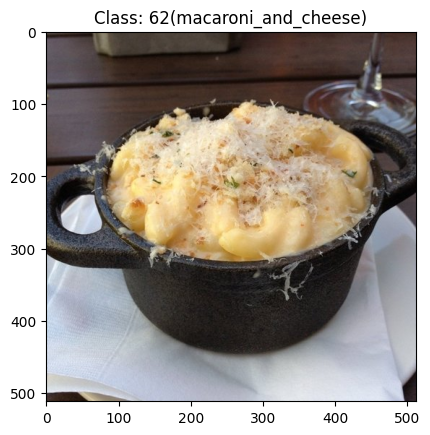

In [34]:
i = np.random.randint(75747)

imagen = trainds[i]['image']
label = trainds[i]['label']
plt.imshow(imagen)
plt.title(f'Class: {label}({id2label[label]})')  
plt.show()

## Selección del Modelo

In [43]:
# Cargo el modelo base
# model_name = 'google/vit-base-patch16-224-in21k'
model_name = 'google/vit-base-patch32-384'
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=numclasses, ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# model.classifier = torch.nn.Linear(in_features=768, out_features=numclasses)
model.config.id2label = id2label
model.config.label2id = label2id

In [45]:
model.classifier

Linear(in_features=768, out_features=101, bias=True)

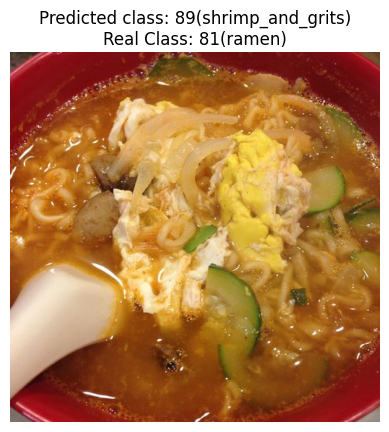

In [49]:
# Pruebo modelo sin entrenar en una imagen
i = np.random.randint(5000)

imagen = trainds[i]['image']
label = trainds[i]['label']
model.to('cpu')
inputs = processor(images=imagen, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])
predicted_class = model.config.id2label[predicted_class_idx]

plt.imshow(imagen)
plt.axis('off') 
plt.title(f'Predicted class: {predicted_class_idx}({predicted_class})\nReal Class: {label}({id2label[label]})')
plt.show()


In [50]:
outputs

ImageClassifierOutput(loss=None, logits=tensor([[ 0.4439,  0.6084, -0.7616, -0.0661, -0.1290,  0.4221,  0.5675,  0.3027,
         -0.8533,  0.1985,  0.1846,  0.4958, -0.4866,  0.0788, -0.3830,  0.4348,
         -0.2021, -0.3143,  0.2782, -0.0536, -0.7545,  0.4510, -0.3752, -0.0280,
         -0.7571,  0.1829, -0.7035,  0.7056, -0.3217,  0.1269,  0.2973,  0.4704,
          0.1990, -0.7290, -0.8414, -0.7191,  0.8784, -0.0656, -0.0342, -0.5414,
         -0.8288,  0.0896,  0.1012,  0.1835, -0.4227, -0.0892, -0.1219, -0.4233,
         -0.8491, -0.7279,  0.0982,  0.8746,  0.3065, -0.8291, -0.5657,  1.1398,
          0.0542, -0.3455,  0.5219,  0.1389, -0.2652,  0.2884,  0.5090,  0.7702,
         -0.6686,  0.1732,  0.1726, -0.7625, -0.0602, -0.9467,  0.2818, -1.6658,
          0.5025,  0.8343, -0.0047, -0.8337, -1.0139,  0.0389,  0.1424,  0.6342,
          0.2767,  1.1266,  0.1829, -0.1397,  0.5547, -0.1619, -0.8533, -1.0332,
          0.1675,  1.1613,  0.9993,  0.5693,  0.3958, -0.2086, -0.296

## Definición de clase Dataset y chequeos previos

In [51]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset        
        self.transform = transform
        # model_name = 'google/vit-base-patch16-224-in21k'
        model_name = 'google/vit-base-patch32-384'
        self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        label = self.dataset[idx]['label']
        image = self.dataset[idx]['image']
        # aplico transformacione estandar requeridas por el modelo
        image = self.processor(images=image, return_tensors="pt")
        # obtengo los valores
        pixel_values = image['pixel_values']
        # Remuevo dimensióne extra
        pixel_values = pixel_values.squeeze()
        if self.transform:
            image = self.transform(image)
        return {'pixel_values':pixel_values, 'label': label}

In [52]:

train_dataset = CustomImageDataset(trainds)
test_dataset = CustomImageDataset(testds)
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [53]:
next(iter(train_dataloader))['pixel_values'].shape

torch.Size([16, 3, 384, 384])

In [54]:
# Evalúo accuracy del modelo base sin fine tuning

device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS


test_dataloader = DataLoader(test_dataset, batch_size=64)

model.to(device)
# Evaluate the model on test data
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch['pixel_values'].float()
        outputs = model(pixel_values=pixel_values.to('cuda'))  # Forward pass
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions.to('cpu') == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cuda


d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Test Accuracy: 1.12%


## Fine Tuning

In [55]:
model_name = 'google/vit-base-patch32-384'
model_ft = ViTForImageClassification.from_pretrained(model_name, num_labels=numclasses, ignore_mismatched_sizes=True)
# model_ft.classifier = torch.nn.Linear(in_features=768, out_features=numclasses, bias=True)
model_ft.config.id2label = id2label
model_ft.config.label2id = label2id
model_ft.config

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vit-base-patch32-384",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",
    "25": "club_sandwich",
    "26": "crab_cakes",
    "27

In [56]:
model_ft.classifier

Linear(in_features=768, out_features=101, bias=True)

In [ ]:
# Fine tuning

training_args = TrainingArguments(
    output_dir="./vit-finetuned-food101",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    log_level = 'info',
    fp16 = True,
    resume_from_checkpoint=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using auto half precision backend
***** Running training *****
  Num examples = 15,000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 705
  Number of trainable parameters = 87,605,861


  0%|          | 0/705 [00:00<?, ?it/s]


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 2.8213438987731934, 'eval_runtime': 20.9128, 'eval_samples_per_second': 95.635, 'eval_steps_per_second': 1.53, 'epoch': 1.0}



***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.977628231048584, 'eval_runtime': 20.9247, 'eval_samples_per_second': 95.581, 'eval_steps_per_second': 1.529, 'epoch': 2.0}


Saving model checkpoint to ./vit-finetuned-food101\checkpoint-500
Configuration saved in ./vit-finetuned-food101\checkpoint-500\config.json


{'loss': 2.945, 'grad_norm': 3.815890312194824, 'learning_rate': 5.815602836879432e-06, 'epoch': 2.13}


Model weights saved in ./vit-finetuned-food101\checkpoint-500\model.safetensors
Saving model checkpoint to ./vit-finetuned-food101\checkpoint-705
Configuration saved in ./vit-finetuned-food101\checkpoint-705\config.json
Model weights saved in ./vit-finetuned-food101\checkpoint-705\model.safetensors

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.7805322408676147, 'eval_runtime': 20.9041, 'eval_samples_per_second': 95.675, 'eval_steps_per_second': 1.531, 'epoch': 3.0}
{'train_runtime': 664.9245, 'train_samples_per_second': 67.677, 'train_steps_per_second': 1.06, 'train_loss': 2.58357851285461, 'epoch': 3.0}


TrainOutput(global_step=705, training_loss=2.58357851285461, metrics={'train_runtime': 664.9245, 'train_samples_per_second': 67.677, 'train_steps_per_second': 1.06, 'total_flos': 1.046358797008896e+19, 'train_loss': 2.58357851285461, 'epoch': 3.0})

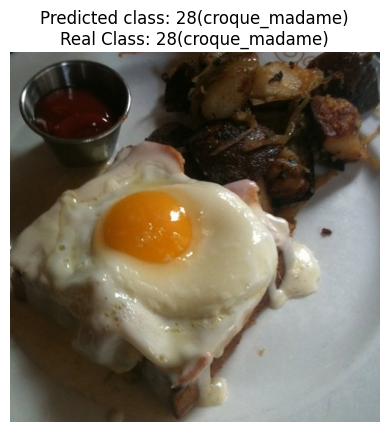

In [278]:
i = np.random.randint(500)

model_ft.to('cpu')
imagen = testds[i]['image']
label = testds[i]['label']
inputs = processor(images=imagen, return_tensors="pt")
outputs = model_ft(**inputs)
# outputs = model_ft(train_dataset[5]['pixel_values'].unsqueeze(0))
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])
predicted_class = model.config.id2label[predicted_class_idx]

plt.imshow(imagen)
plt.axis('off') 
plt.title(f'Predicted class: {predicted_class_idx}({predicted_class})\nReal Class: {label}({id2label[label]})')
plt.show()

In [282]:
# Evalúo accuracy del modelo base sin fine tuning

device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS


test_dataloader = DataLoader(test_dataset, batch_size=64)

model_ft.to(device)
# Evaluate the model on test data
model_ft.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch['pixel_values'].float()
        outputs = model_ft(pixel_values=pixel_values.to('cuda'))  # Forward pass
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions.to('cpu') == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cuda
Test Accuracy: 71.85%


In [283]:
# liberar memoria
torch.cuda.empty_cache()

In [284]:
outputs = trainer.predict(test_dataset)


***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


  0%|          | 0/32 [00:00<?, ?it/s]

In [285]:
outputs.metrics

{'test_loss': 1.7805322408676147,
 'test_runtime': 25.2741,
 'test_samples_per_second': 79.132,
 'test_steps_per_second': 1.266}

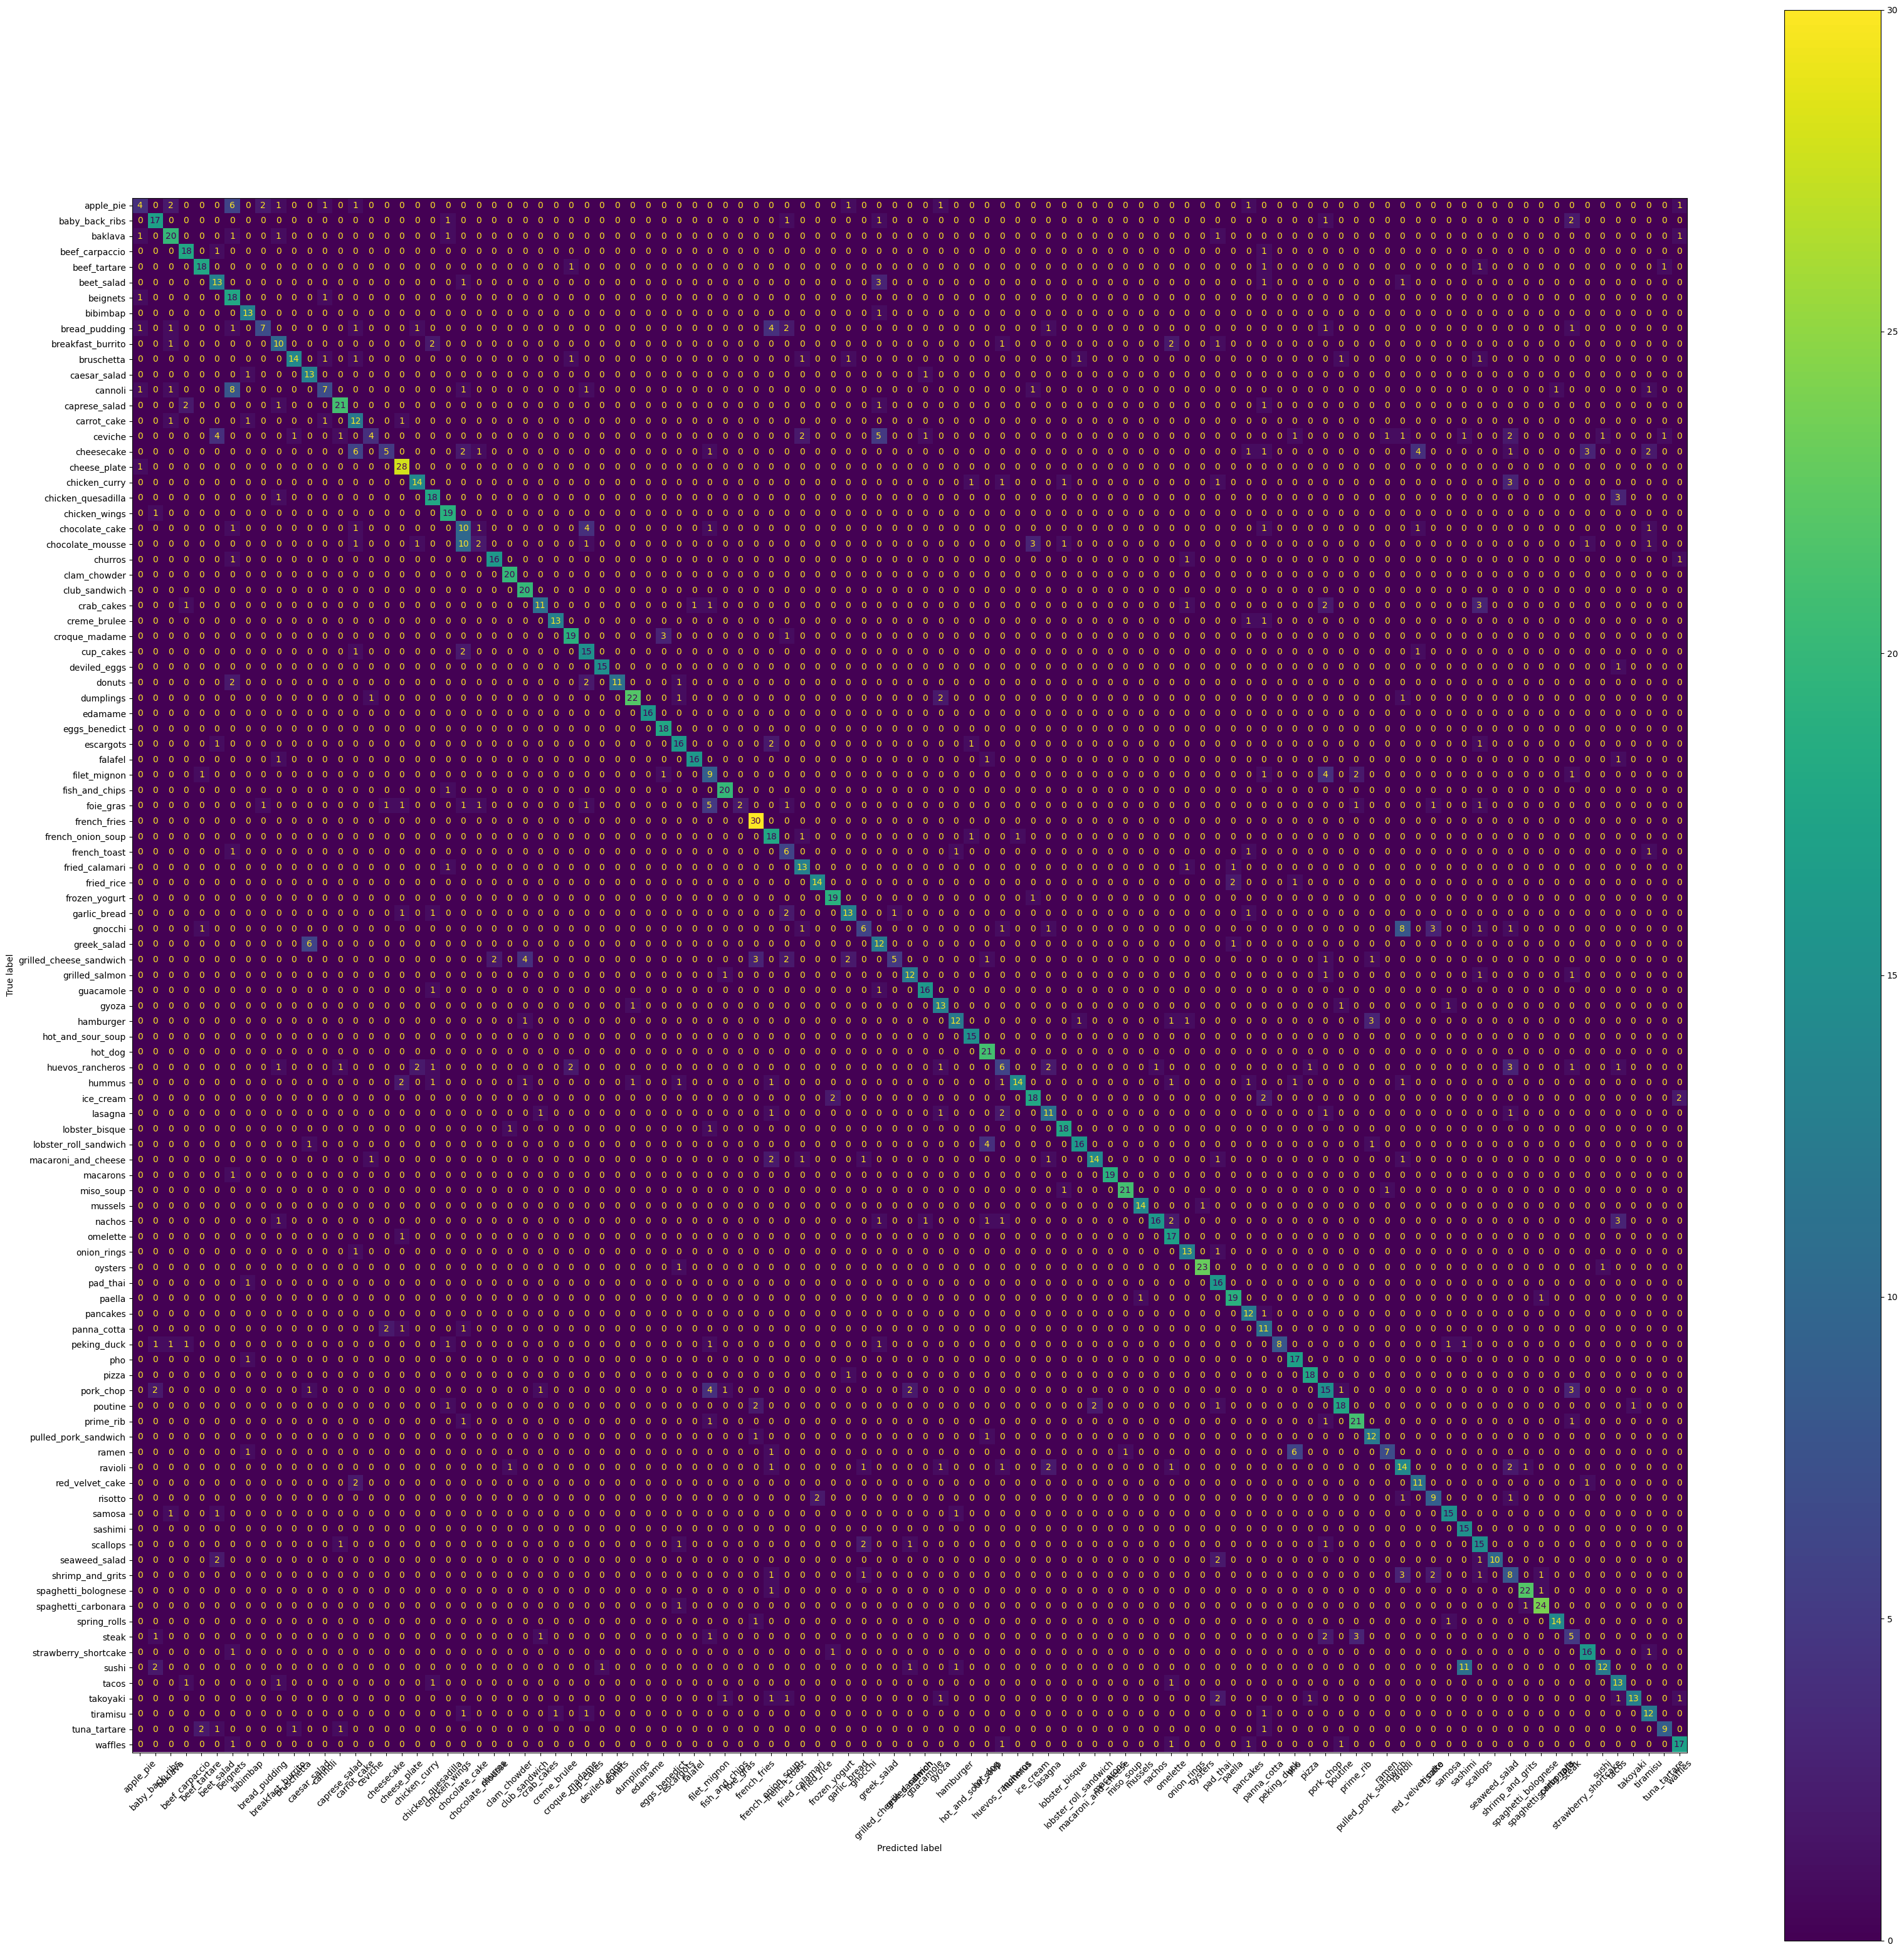

In [296]:
# Confussion Matrix
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(40, 40))


labels = id2label
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

y_pred_filtered = np.where(y_pred < len(labels), y_pred, -1)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = labels.values()
cm = confusion_matrix(y_true, y_pred_filtered)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, ax=ax)

## Guardo el modelo

In [297]:
output_model_dir = 'trained_model'
if trainer.is_fsdp_enabled:
    trainer.accelerator.state.fsdp_plugin.set_state_dict_type("FULL_STATE_DICT")
trainer.save_model(output_model_dir)

Saving model checkpoint to trained_model
Configuration saved in trained_model\config.json
Model weights saved in trained_model\model.safetensors


## Uso el modelo guardado

In [72]:

model_dir = 'trained_model2'
model_new = ViTForImageClassification.from_pretrained(model_dir)


loading configuration file trained_model2\config.json
Model config ViTConfig {
  "_name_or_path": "trained_model2",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",
    "25": "club_sandwich",
    "26": "crab_c

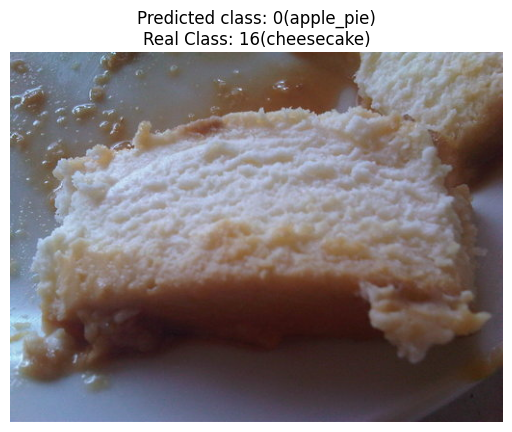

In [81]:
i = np.random.randint(10000)
imagen = testds[i]['image']
label = testds[i]['label']
inputs = processor(images=imagen, return_tensors="pt")
outputs = model_new(**inputs)
# outputs = model_ft(train_dataset[5]['pixel_values'].unsqueeze(0))
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])
predicted_class = model_new.config.id2label[predicted_class_idx]

plt.imshow(imagen)
plt.axis('off') 
plt.title(f'Predicted class: {predicted_class_idx}({predicted_class})\nReal Class: {label}({id2label[label]})')
plt.show()

## Entreno de nuevo pero desde le modelo entrenado con todos los datos, esta vez.

In [68]:
# Fine tuning

training_args = TrainingArguments(
    output_dir="./vit-finetuned-food101",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    log_level = 'info',
    fp16 = True,
    resume_from_checkpoint=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model_new,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    #compute_metrics=compute_metrics,
)

trainer.train()

Using auto half precision backend
***** Running training *****
  Num examples = 75,747
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 3,552
  Number of trainable parameters = 87,605,861


  0%|          | 0/3552 [00:00<?, ?it/s]

Saving model checkpoint to ./vit-finetuned-food101\checkpoint-500
Configuration saved in ./vit-finetuned-food101\checkpoint-500\config.json


{'loss': 0.8588, 'grad_norm': 3.3809003829956055, 'learning_rate': 1.7184684684684688e-05, 'epoch': 0.42}


Model weights saved in ./vit-finetuned-food101\checkpoint-500\model.safetensors
Saving model checkpoint to ./vit-finetuned-food101\checkpoint-1000
Configuration saved in ./vit-finetuned-food101\checkpoint-1000\config.json


{'loss': 0.7218, 'grad_norm': 4.480876445770264, 'learning_rate': 1.4369369369369371e-05, 'epoch': 0.84}


Model weights saved in ./vit-finetuned-food101\checkpoint-1000\model.safetensors

***** Running Evaluation *****
  Num examples = 25250
  Batch size = 64


  0%|          | 0/395 [00:00<?, ?it/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


{'eval_loss': 0.5225834846496582, 'eval_runtime': 469.3649, 'eval_samples_per_second': 53.796, 'eval_steps_per_second': 0.842, 'epoch': 1.0}


Saving model checkpoint to ./vit-finetuned-food101\checkpoint-1500
Configuration saved in ./vit-finetuned-food101\checkpoint-1500\config.json


{'loss': 0.5357, 'grad_norm': 4.340124130249023, 'learning_rate': 1.1554054054054056e-05, 'epoch': 1.27}


Model weights saved in ./vit-finetuned-food101\checkpoint-1500\model.safetensors
Saving model checkpoint to ./vit-finetuned-food101\checkpoint-2000
Configuration saved in ./vit-finetuned-food101\checkpoint-2000\config.json


{'loss': 0.441, 'grad_norm': 3.0667457580566406, 'learning_rate': 8.738738738738739e-06, 'epoch': 1.69}


Model weights saved in ./vit-finetuned-food101\checkpoint-2000\model.safetensors

***** Running Evaluation *****
  Num examples = 25250
  Batch size = 64


  0%|          | 0/395 [00:00<?, ?it/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


{'eval_loss': 0.4686613976955414, 'eval_runtime': 441.6431, 'eval_samples_per_second': 57.173, 'eval_steps_per_second': 0.894, 'epoch': 2.0}


Saving model checkpoint to ./vit-finetuned-food101\checkpoint-2500
Configuration saved in ./vit-finetuned-food101\checkpoint-2500\config.json


{'loss': 0.3996, 'grad_norm': 2.644631862640381, 'learning_rate': 5.923423423423423e-06, 'epoch': 2.11}


Model weights saved in ./vit-finetuned-food101\checkpoint-2500\model.safetensors
Saving model checkpoint to ./vit-finetuned-food101\checkpoint-3000
Configuration saved in ./vit-finetuned-food101\checkpoint-3000\config.json


{'loss': 0.298, 'grad_norm': 2.714909076690674, 'learning_rate': 3.113738738738739e-06, 'epoch': 2.53}


Model weights saved in ./vit-finetuned-food101\checkpoint-3000\model.safetensors
Saving model checkpoint to ./vit-finetuned-food101\checkpoint-3500
Configuration saved in ./vit-finetuned-food101\checkpoint-3500\config.json


{'loss': 0.2923, 'grad_norm': 2.0908610820770264, 'learning_rate': 2.9842342342342343e-07, 'epoch': 2.96}


Model weights saved in ./vit-finetuned-food101\checkpoint-3500\model.safetensors
Saving model checkpoint to ./vit-finetuned-food101\checkpoint-3552
Configuration saved in ./vit-finetuned-food101\checkpoint-3552\config.json
Model weights saved in ./vit-finetuned-food101\checkpoint-3552\model.safetensors

***** Running Evaluation *****
  Num examples = 25250
  Batch size = 64


  0%|          | 0/395 [00:00<?, ?it/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.4604227542877197, 'eval_runtime': 444.7643, 'eval_samples_per_second': 56.772, 'eval_steps_per_second': 0.888, 'epoch': 3.0}
{'train_runtime': 6390.9949, 'train_samples_per_second': 35.556, 'train_steps_per_second': 0.556, 'train_loss': 0.5033702922833933, 'epoch': 3.0}


TrainOutput(global_step=3552, training_loss=0.5033702922833933, metrics={'train_runtime': 6390.9949, 'train_samples_per_second': 35.556, 'train_steps_per_second': 0.556, 'total_flos': 5.283902653135523e+19, 'train_loss': 0.5033702922833933, 'epoch': 3.0})

In [70]:
output_model_dir = 'trained_model2'
if trainer.is_fsdp_enabled:
    trainer.accelerator.state.fsdp_plugin.set_state_dict_type("FULL_STATE_DICT")
trainer.save_model(output_model_dir)

Saving model checkpoint to trained_model2
Configuration saved in trained_model2\config.json
Model weights saved in trained_model2\model.safetensors


In [83]:
# Evalúo accuracy del modelo base sin fine tuning

device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS


test_dataloader = DataLoader(test_dataset, batch_size=64)

model_new.to(device)
# Evaluate the model on test data
model_new.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch['pixel_values'].float()
        outputs = model_new(pixel_values=pixel_values.to('cuda'))  # Forward pass
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions.to('cpu') == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cuda
Test Accuracy: 87.57%
